# Modelling notebook 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import warnings # supress warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/SIADS_591/Project

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Mounted at /content/drive
/content/drive/My Drive/SIADS_591/Project


# Read Secondary datasets and clean them

Crime level dataset

In [ ]:
crime_df = pd.read_csv('Datasets/MPS_borough_level_crime.csv')
crime_sum = crime_df.groupby('LookUp_BoroughName').agg('sum').reset_index() #Summing all crimes
crime_sum['total_crimes'] = crime_sum.sum(axis=1)
crime_sum = crime_sum[['LookUp_BoroughName','total_crimes']].rename(columns={'LookUp_BoroughName':'Borough'})
# London Heathrow and London City Airports = City of London
crime_sum['Borough'] = crime_sum['Borough'].replace(['London Heathrow and London City Airports'], 'City of London') # Not right - leave it out 
land_area_pop_df = pd.read_excel('Datasets/land_area_population_density.xlsx','Borough', skiprows = 1, usecols = ["Area name", "Census population (2011)", "Population per square kilometre"]).iloc[1:34]
land_area_pop_df = land_area_pop_df.rename(columns={'Area name': 'Borough', 'Census population (2011)': 'pop2011', "Population per square kilometre": "popperkmsquare"})
property_prices_df = pd.read_excel('Datasets/London_property_prices.xlsx')
property_prices_df = property_prices_df.iloc[: , :2]
property_prices_df.columns = ['Borough','property_price']
property_prices_df['Borough'] = property_prices_df['Borough'].replace(['City of Westminster'],'Westminster') # City of Westminster = Westminster

Merging all three datasets

In [ ]:
from functools import reduce

# compile the list of dataframes you want to merge
data_frames = [crime_sum, land_area_pop_df, property_prices_df]
df_merged = reduce(lambda  left,right: pd.merge(left, right,on = ['Borough'], how = 'outer'), data_frames)

# Clean property_price column to integer value 
df_merged['property_price'] = df_merged['property_price'].str.replace("£", "")
df_merged['property_price'] = df_merged['property_price'].str.replace(",", "")
df_merged = df_merged.set_index('Borough').apply(pd.to_numeric).reset_index() # converting to rest of columns to numeric format
df_merged.head(5)

# normalising crime by respective Borough's 2011 population
df_merged['crime_per_pop'] = df_merged['total_crimes']/df_merged['pop2011']


## Read Primary Dataset - Cleaning 

In [ ]:
listings_df = pd.read_csv('Datasets/listings.csv')

In [ ]:
#### London underground data 
tube1 = pd.read_html('https://commons.wikimedia.org/wiki/London_Underground_geographic_maps/Tables')
tube_data = tube1[0]

#### convert lat long to an array
lat_long_data1 = np.array(list(zip(listings_df['latitude'], listings_df['longitude'])))
tube_lat_long = np.array(list(zip(tube_data['latitude'], tube_data['longitude'])))

In [ ]:
#### Convert latitude longitude from degrees to Radians
data1 = np.deg2rad(lat_long_data1)
data2 = np.deg2rad(tube_lat_long)

#### Keep latitudes and longitudes to separate array 
lat1 = data1[:,0]
lng1 = data1[:,1]

lat2 = data2[:,0]
lng2 = data2[:,1]

In [ ]:
#### Compute a 67903 X 307 array with each row containing the distance in Km of each Airbnb property from each of the 307 tube
### Stations
diff_lat = lat1[:,None] - lat2
diff_lng = lng1[:,None] - lng2
d = np.sin(diff_lat/2)**2 + np.cos(lat1[:,None])*np.cos(lat2) * np.sin(diff_lng/2)**2
dist_final = 2 * 6371 * np.arcsin(np.sqrt(d))

In [ ]:
#### find the closest station for each row
min_dist = list(np.min(dist_final, axis = 1))
#### find number of stations within 1 km
dist_1k_cnt = list(np.sum(dist_final < 1, axis = 1))

final_data1 = list(zip(min_dist,dist_1k_cnt))
data_stations = pd.DataFrame(final_data1, columns = ['closest_station_dist', 'within_1k_station_num'])

In [ ]:
#### Vertically concatenate the two new columns create in the above cell
listing_df_ns = pd.concat([listings_df,data_stations], axis = 1)

In [ ]:
places_of_interest_df = pd.read_excel('Datasets/places_of_interest.xlsx')
places_of_interest_df = places_of_interest_df.loc[places_of_interest_df['Area'] == "London"]

lat_long_data1 = np.array(list(zip(listing_df_ns['latitude'], listing_df_ns['longitude'])))
places_lat_long = np.array(list(zip(places_of_interest_df['Latitude'], places_of_interest_df['Longitude'])))
#### Convert latitude longitude from degrees to Radians
data1 = np.deg2rad(lat_long_data1)
data2 = np.deg2rad(places_lat_long)

#### Keep latitudes and longitudes to separate array 
lat1 = data1[:,0]
lng1 = data1[:,1]

lat2 = data2[:,0]
lng2 = data2[:,1]

#### Compute a 44000 X 41 array with each row containing the distance in Km of each Airbnb property from each of the 307 tube
### Stations
diff_lat = lat1[:,None] - lat2
diff_lng = lng1[:,None] - lng2
d = np.sin(diff_lat/2)**2 + np.cos(lat1[:,None])*np.cos(lat2) * np.sin(diff_lng/2)**2
dist_final = 2 * 6371 * np.arcsin(np.sqrt(d))

d1 = np.round(np.min(dist_final, axis = 1),0)
df1 = pd.DataFrame({'x': list(d1)})

#### find the closest tourist attractions for each row
min_dist_tourist = list(np.round(np.min(dist_final, axis = 1),1))
#### find number of tourist attractions within 5 km
dist_5k_tourist_num = list(np.sum(dist_final < 5 , axis = 1))

final_data1 = list(zip(min_dist_tourist,dist_5k_tourist_num))
data_places = pd.DataFrame(final_data1, columns = ['min_dist_tourist', 'dist_5k_tourist_num'])

In [ ]:
#### Vertically concatenate the two new columns create in the above cell
listing_df_ns = pd.concat([listing_df_ns,data_places], axis = 1)
listing_df_ns.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,closest_station_dist,within_1k_station_num,min_dist_tourist,dist_5k_tourist_num
0,13913,https://www.airbnb.com/rooms/13913,20211010233627,2021-10-12,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within an hour,92%,82%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56861,-0.11270,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Pack \u2019n play/Travel crib"", ""Smoke alarm...",$65.00,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,5,34,64,339,2021-10-12,21,0,0,2011-07-11,2011-09-13,4.85,4.79,4.84,4.79,4.89,4.63,4.74,NaN,f,2,1,1,0,0.17,0.651237,1,4.1,3
1,15400,https://www.airbnb.com/rooms/15400,20211010233627,2021-10-12,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",within an hour,75%,50%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48780,-0.16813,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Air conditioning"", ""Heating"", ""Fire extingui...",$75.00,3,50,3.0,3.0,50.0,50.0,3.0,50.0,NaN,t,0,0,0,2,2021-10-12,89,0,0,2012-07-16,2019-08-10,4.79,4.84,4.88,4.87,4.82,4.93,4.73,NaN,f,1,1,0,0,0.79,0.803020,2,1.0,20
2,17402,https://www.airbnb.com/rooms/17402,20211010233627,2021-10-12,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564,https://www.airbnb.com/users/show/67564,Liz,2010-01-04,"Brighton and Hove, England, United Kingdom",We are Liz and Jack. We manage a number of ho...,within a day,60%,62%,f,https://a0.muscache.com/im/users/67564/profile...,https://a0.muscache.com/im/users/67564/profile...,Fitzrovia,18.0,18.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, Fitzrovia, United Kingdom",Westminster,NaN,51.52195,-0.14094,Entire rental unit,Entire 

### Counting amenities by airbnb property (row-wise) - count by (',') in list of words in amenities column

In [ ]:
listing_df_ns['amenities_count'] = listing_df_ns['amenities'].str.count(',')

### Selecting variables for modelling given EDA results & discussion

Selecting only required columns for Multiple Regressions Analysis

In [ ]:
#### Remove records where host identity verified field is missing. # Records dropped = 32. # Records left = 67871
listing1 = listing_df_ns[listing_df_ns['host_identity_verified'].isnull() == 0]


#### Remove listings which have not been reviewed on each of the parameters. # Records dropped = 20463. # Records left = 47408
listing2 = listing1.dropna(subset = ["number_of_reviews", "review_scores_rating","review_scores_accuracy",\
                     "review_scores_cleanliness","review_scores_checkin","review_scores_communication",\
                     "review_scores_location","review_scores_value"] )

##drop records where key variables like beds, bedrooms and bathrooms are missing. # Records dropped = 2963.
# Records left = 44445
listing3 = listing2.dropna(subset = ['bedrooms', 'bathrooms_text','beds'])

##Removing properties with price = $0.00 # Records dropped = 2.# Records left = 44443
listing4 = listing3[listing3['price'] != '$0.00']



# Using insights drawn from EDA & logical inference - these variables were picked to model for airbnb prices
listings_df_features = listing4[['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable', 'room_type',
                                      'neighbourhood_cleansed', 'accommodates',"bedrooms", "beds", "minimum_nights", "maximum_nights", 
                                      "number_of_reviews", "review_scores_rating","closest_station_dist", "within_1k_station_num", "min_dist_tourist", 
                                      "dist_5k_tourist_num", "amenities_count",'calculated_host_listings_count', "price"]].dropna()

listings_df_features.shape

(44443, 20)

## Adding secondary data sources into the selected variable dataset before converting into dummy variables

In [ ]:
df_all = pd.merge(df_merged, listings_df_features,  how ='inner', left_on = ['Borough'], right_on = ['neighbourhood_cleansed'])
df_all = df_all.drop(['neighbourhood_cleansed'], axis = 1)
df_all.columns

Index(['Borough', 'total_crimes', 'popperkmsquare', 'pop2011',
       'property_price', 'crime_per_pop', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'instant_bookable',
       'room_type', 'accommodates', 'bedrooms', 'beds', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'closest_station_dist', 'within_1k_station_num', 'min_dist_tourist',
       'dist_5k_tourist_num', 'amenities_count',
       'calculated_host_listings_count', 'price'],
      dtype='object')

In [ ]:
df_all['price'] = df_all['price'].str.replace("$", "")
df_all['price'] = df_all['price'].str.replace(",", "")

## Our multiple regression analysis will use this dataset, the following steps create dummy variables and converts all features to numeric data type format 

In [ ]:
# Dummy variables creation
host_has_profile_pic_dummy = pd.get_dummies(df_all["host_has_profile_pic"]).rename(columns={'f': 'host_has_profile_pic_f', 't': 'host_has_profile_pic_t'})
host_is_superhost_dummy = pd.get_dummies(df_all["host_is_superhost"]).rename(columns={'f': 'host_is_superhost_dummy_f', 't': 'host_is_superhost_dummy_t'})
host_identity_verified_dummy = pd.get_dummies(df_all["host_identity_verified"]).rename(columns={'f': 'host_identity_verified_f', 't': 'host_identity_verified_t'})
instant_bookable_dummy = pd.get_dummies(df_all["instant_bookable"]).rename(columns={'f': 'instant_bookable_f', 't': 'instant_bookable_t'})
room_type_dummy = pd.get_dummies(df_all["room_type"])
borough_dummy = pd.get_dummies(df_all["Borough"])
listings_df_features = df_all[['accommodates', "minimum_nights", "maximum_nights", "number_of_reviews", "review_scores_rating","closest_station_dist", "within_1k_station_num", 
                               "min_dist_tourist", "dist_5k_tourist_num", 'total_crimes', 'popperkmsquare', 'pop2011','property_price', 'crime_per_pop', "amenities_count", 'calculated_host_listings_count', "price"]]

# Combining the non dummy wtih dummy variables datasets
features = pd.concat([host_is_superhost_dummy, host_has_profile_pic_dummy, host_identity_verified_dummy, instant_bookable_dummy, borough_dummy, room_type_dummy, listings_df_features], axis=1)
features['price'] = features['price'].str.replace("$", "")
features['price'] = features['price'].str.replace(",", "")
features = features.apply(pd.to_numeric)
features = features[features.price > 0] # removing where price = 0
#features.dtypes

# Avoiding the Dummy variable trap - The base regression will be city of london, private room, host is superhost, host has profile pic, host identity is verified and instantly bookable

In [ ]:
features.columns

Index(['host_is_superhost_dummy_f', 'host_is_superhost_dummy_t',
       'host_has_profile_pic_f', 'host_has_profile_pic_t',
       'host_identity_verified_f', 'host_identity_verified_t',
       'instant_bookable_f', 'instant_bookable_t', 'Barking and Dagenham',
       'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden', 'City of London',
       'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney',
       'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster',
       'Entire home/apt', 'Hotel room', 'Private room', 'Shared room',
       'accommodates', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'closest_station_dist', 'within_1k_station_num',
       'min_dist_t

In [ ]:
features=features.drop(['host_is_superhost_dummy_t','host_has_profile_pic_t','host_identity_verified_t','instant_bookable_t','City of London','Private room'],1)

In [ ]:
# check that there are no rows with price = 0
(features.price == 0).sum()

0

## Outlier Detection 

In [ ]:
features['price'].describe()

count    44443.000000
mean       120.577909
std        235.866435
min          8.000000
25%         45.000000
50%         83.000000
75%        139.000000
max      18012.000000
Name: price, dtype: float64

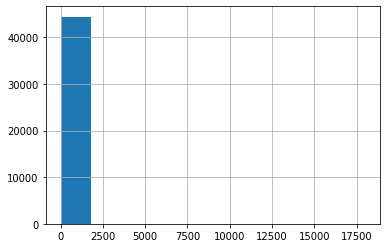

In [ ]:
features.price.hist()

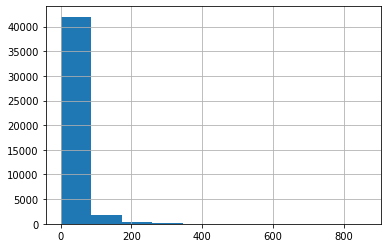

In [ ]:
features.number_of_reviews.hist()

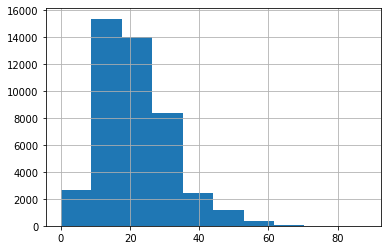

In [ ]:
features.amenities_count.hist()

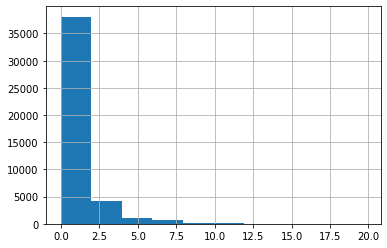

In [ ]:
features.closest_station_dist.hist()

## Quantile-based Flooring and Capping

In [ ]:
print(features['price'].quantile(0.05))
print(features['price'].quantile(0.95))

25.0
308.0


### Cleaning based of these two ranges

In [ ]:
features['price'] = np.where(features['price'] < features['price'].quantile(0.05), features['price'].quantile(0.05), features['price'])
features['price']= np.where(features['price'] > features['price'].quantile(0.95), features['price'].quantile(0.95), features['price'])
print(features['price'].skew())

1.2663177121339437


In [ ]:
features['calculated_host_listings_count'] = np.where(features['calculated_host_listings_count'] < features['calculated_host_listings_count'].quantile(0.05), features['calculated_host_listings_count'].quantile(0.05), features['calculated_host_listings_count'])
features['calculated_host_listings_count']= np.where(features['calculated_host_listings_count'] > features['calculated_host_listings_count'].quantile(0.95), features['calculated_host_listings_count'].quantile(0.95), features['calculated_host_listings_count'])
print(features['calculated_host_listings_count'].skew())

2.8255043954414862


In [ ]:
features['amenities_count'] = np.where(features['amenities_count'] < features['amenities_count'].quantile(0.05), features['amenities_count'].quantile(0.05), features['amenities_count'])
features['amenities_count']= np.where(features['amenities_count'] > features['amenities_count'].quantile(0.95), features['amenities_count'].quantile(0.95), features['amenities_count'])
print(features['amenities_count'].skew())

0.49149297828504956


In [ ]:
features['min_dist_tourist'] = np.where(features['min_dist_tourist'] < features['min_dist_tourist'].quantile(0.05), features['min_dist_tourist'].quantile(0.05), features['min_dist_tourist'])
features['min_dist_tourist']= np.where(features['min_dist_tourist'] > features['min_dist_tourist'].quantile(0.95), features['min_dist_tourist'].quantile(0.95), features['min_dist_tourist'])
print(features['min_dist_tourist'].skew())

1.1098644432549047


In [ ]:
features['number_of_reviews'] = np.where(features['number_of_reviews'] < features['number_of_reviews'].quantile(0.05), features['number_of_reviews'].quantile(0.05), features['number_of_reviews'])
features['number_of_reviews']= np.where(features['number_of_reviews'] > features['number_of_reviews'].quantile(0.95), features['number_of_reviews'].quantile(0.95), features['number_of_reviews'])
print(features['number_of_reviews'].skew())

1.8536966016064513


# OLS Modelling

In [ ]:
## Without a constant

import statsmodels.api as sm

X = features.iloc[:,:-1]
y = features[['price']]
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     1310.
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:30:53   Log-Likelihood:            -2.3559e+05
No. Observations:               44443   AIC:                         4.713e+05
Df Residuals:                   44392   BIC:                         4.717e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
host_is_superhost_dummy_f         -3.8729      0.645     -6.001      0.000      -5.138      -2.608
host_has_profile_pic_f             6.5311      3.668      1.781      0.075      -0.658      13.721
host_identity_verified_f          -1.1058      0.638     -1.734      0.083      -2.356       0.144
instant_bookable_f                 2.3379      0.512      4.562      0.000       1.334       3.342
Barking and Dagenham              -0.6922      3.537     -0.196      0.845      -7.625       6.241
Barnet                            -4.5493      2.194     -2.074      0.038      -8.849      -0.249
Bexley                            -0.6398      3.916     -0.163      0.870      -8.314       7.035
Brent                              6.0971      1.571      3.882      0.000       3.018       9.176
Bromley                           -9.1527      2.809     -3.258      0.001     -14.659      -3.647
Camden                            -2.6406      1.106     -2.387      0.017      -4.809      -0.472
Croydon                           -9.4336      2.242     -4.208      0.000     -13.827      -5.040
Ealing                             0.3070      1.793      0.171      0.864      -3.208       3.822
Enfield                            3.0651      2.499      1.227      0.220      -1.833       7.963
Greenwich                         -5.2873      1.601     -3.302      0.001      -8.426      -2.148
Hackney                           -0.1352      1.131     -0.120      0.905      -2.351       2.081
Hammersmith and Fulham             5.8560      1.472      3.979      0.000       2.972       8.740
Haringey                           1.3547      1.453      0.932      0.351      -1.494       4.203
Harrow                             8.5929      2.957      2.906      0.004       2.796      14.389
Havering                           4.3651      3.694      1.182      0.237      -2.874      11.605
Hillingdon                        -0.1306      2.446     -0.053      0.957      -4.925       4.663
Hounslow                           2.0852      1.924      1.084      0.278      -1.686       5.856
Islington                         -2.1732      0.999     -2.175      0.030      -4.131      -0.215
Kensington and Chelsea            22.6378      3.441      6.578      0.000      15.893      29.383
Kingston upon Thames              -6.7322      2.984     -2.256      0.024     -12.582      -0.883
Lambeth                           -4.2873      1.199     -3.577      0.000      -6.637      -1.938
Lewisham                         -19.7585      1.512    -13.072      0.000     -22.721     -16.796
Merton                            17.6204      2.044      8.622      0.000      13.615      21.626
Newham                             4.5751      1.814      2.523      0.012       1.020       8.130
Redbridge     

# Selecting variables with coefficient values and low p-values 

In [ ]:
features_1 = features[['host_is_superhost_dummy_f', 'instant_bookable_f', 'Barnet', 'Brent','Bromley','Croydon','Greenwich','Hammersmith and Fulham','Harrow','Islington','Kensington and Chelsea','Lambeth','Lewisham','Merton','Newham',
                     'Richmond upon Thames','Southwark','Tower Hamlets','Waltham Forest','Wandsworth','Westminster','Entire home/apt','Hotel room','Shared room','accommodates','number_of_reviews','review_scores_rating','within_1k_station_num',
                     'min_dist_tourist','dist_5k_tourist_num','total_crimes','popperkmsquare','property_price','crime_per_pop','amenities_count','closest_station_dist','calculated_host_listings_count','price']]

X = features_1.iloc[:,:-1]
y = features_1[['price']]
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.859
Model:                            OLS   Adj. R-squared (uncentered):              0.859
Method:                 Least Squares   F-statistic:                              7341.
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                        0.00
Time:                        17:30:53   Log-Likelihood:                     -2.3560e+05
No. Observations:               44443   AIC:                                  4.713e+05
Df Residuals:                   44406   BIC:                                  4.716e+05
Df Model:                          37                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
host_is_superhost_dummy_f         -3.9866      0.636     -6.268      0.000      -5.233      -2.740
instant_bookable_f                 2.2925      0.512      4.482      0.000       1.290       3.295
Barnet                            -5.7085      2.029     -2.813      0.005      -9.686      -1.732
Brent                              4.3575      1.555      2.803      0.005       1.310       7.405
Bromley                           -9.0444      3.243     -2.789      0.005     -15.400      -2.689
Croydon                          -11.7419      3.012     -3.899      0.000     -17.645      -5.839
Greenwich                         -7.0559      1.937     -3.642      0.000     -10.853      -3.259
Hammersmith and Fulham             9.7531      2.124      4.593      0.000       5.591      13.916
Harrow                             8.2462      3.328      2.478      0.013       1.723      14.769
Islington                          0.0731      1.762      0.041      0.967      -3.380       3.526
Kensington and Chelsea            34.3288      4.876      7.041      0.000      24.773      43.885
Lambeth                           -5.0356      1.164     -4.327      0.000      -7.317      -2.755
Lewisham                         -20.8961      1.575    -13.267      0.000     -23.983     -17.809
Merton                            18.9631      2.674      7.091      0.000      13.721      24.205
Newham                             1.3829      2.101      0.658      0.510      -2.735       5.501
Richmond upon Thames              15.1862      3.085      4.923      0.000       9.140      21.232
Southwark                         -9.3068      1.335     -6.969      0.000     -11.924      -6.689
Tower Hamlets                    -16.7478      1.707     -9.814      0.000     -20.093     -13.403
Waltham Forest                    -7.7402      1.861     -4.160      0.000     -11.387      -4.093
Wandsworth                        13.5768      1.553      8.744      0.000      10.534      16.620
Westminster                       14.8564      3.271      4.542      0.000       8.445      21.268
Entire home/apt                   35.0236      0.587     59.710      0.000      33.874      36.173
Hotel room                        40.8587      3.642     11.218      0.000      33.720      47.998
Shared room                      -25.1863      3.293     -7.649      0.000     -31.640     -18.733
accommodates                      17.1225      0.146    117.625      0.000      16.837      17.408
number_of_reviews                 -0.2195      0.010    -21.664      0.000      -0.239      -0.200
review_scores_rating               2.9835      0.419      7.123      0.000       2.162       3.804
within_1k_stat

# Feature Importance

## Further removal of non significant variables

In [ ]:
features_2 = features_1[['Entire home/apt', 'accommodates','property_price', 'Southwark', 'calculated_host_listings_count','dist_5k_tourist_num','min_dist_tourist',
                     'amenities_count','within_1k_station_num','Kensington and Chelsea','review_scores_rating','Hotel room','closest_station_dist','Shared room','number_of_reviews','Merton','price']]
X = features_2.iloc[:,:-1]
y = features_2[['price']]
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.856
Model:                            OLS   Adj. R-squared (uncentered):              0.856
Method:                 Least Squares   F-statistic:                          1.652e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                        0.00
Time:                        17:30:54   Log-Likelihood:                     -2.3613e+05
No. Observations:               44443   AIC:                                  4.723e+05
Df Residuals:                   44427   BIC:                                  4.724e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Entire home/apt                   35.1907      0.589     59.751      0.000      34.036      36.345
accommodates                      16.8335      0.146    115.173      0.000      16.547      17.120
property_price                  3.755e-05    1.5e-06     25.018      0.000    3.46e-05    4.05e-05
Southwark                         -2.5648      1.029     -2.493      0.013      -4.582      -0.548
calculated_host_listings_count     1.2037      0.027     44.649      0.000       1.151       1.257
dist_5k_tourist_num                0.5275      0.036     14.470      0.000       0.456       0.599
min_dist_tourist                  -2.1609      0.159    -13.632      0.000      -2.472      -1.850
amenities_count                    0.7040      0.027     25.893      0.000       0.651       0.757
within_1k_station_num              2.5542      0.145     17.605      0.000       2.270       2.839
Kensington and Chelsea            -1.5525      1.506     -1.031      0.303      -4.505       1.400
review_scores_rating              -3.4954      0.247    -14.159      0.000      -3.979      -3.011
Hotel room                        39.7774      3.676     10.820      0.000      32.572      46.983
closest_station_dist               0.1946      0.183      1.063      0.288      -0.164       0.553
Shared room                      -27.6578      3.328     -8.310      0.000     -34.181     -21.135
number_of_reviews                 -0.1933      0.010    -19.561      0.000      -0.213      -0.174
Merton                            15.7743      1.949      8.093      0.000      11.954      19.595
==============================================================================
Omnibus:                    10946.048   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35629.826
Skew:                           1.247   Prob(JB):                         0.00
Kurtosis:                       6.608   Cond. No.                     1.13e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Checking for multicollinearity

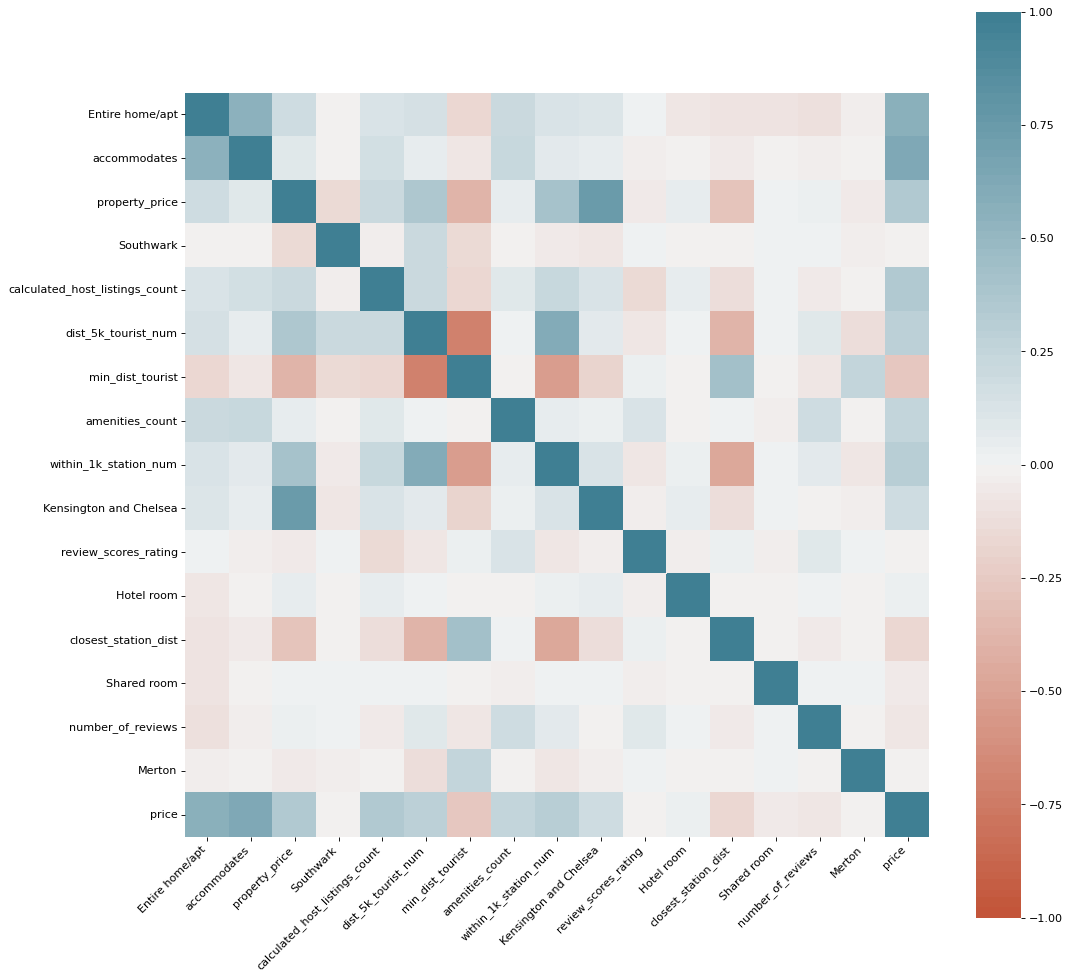

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15, 15), dpi=80)

corr = features_2.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=100),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# removal of pop2011, kensington and chelsea, Southwark, within_1km_station_num


features_3 = features_2[['Entire home/apt', 'accommodates', 'property_price','calculated_host_listings_count', 'Southwark', 'dist_5k_tourist_num','closest_station_dist',
                     'amenities_count','number_of_reviews','within_1k_station_num','Hotel room','Shared room','price']]
X = features_3.iloc[:,:-1]
y = features_3[['price']]
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.853
Model:                            OLS   Adj. R-squared (uncentered):              0.853
Method:                 Least Squares   F-statistic:                          2.149e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                        0.00
Time:                        17:30:55   Log-Likelihood:                     -2.3659e+05
No. Observations:               44443   AIC:                                  4.732e+05
Df Residuals:                   44431   BIC:                                  4.733e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Entire home/apt                   35.9885      0.593     60.647      0.000      34.825      37.152
accommodates                      16.0136      0.145    110.646      0.000      15.730      16.297
property_price                  2.301e-05   8.37e-07     27.477      0.000    2.14e-05    2.47e-05
calculated_host_listings_count     1.2674      0.027     46.940      0.000       1.214       1.320
Southwark                         -5.4162      1.024     -5.289      0.000      -7.423      -3.409
dist_5k_tourist_num                0.7004      0.031     22.682      0.000       0.640       0.761
closest_station_dist              -2.2718      0.166    -13.712      0.000      -2.597      -1.947
amenities_count                    0.3503      0.024     14.349      0.000       0.302       0.398
number_of_reviews                 -0.2173      0.010    -21.875      0.000      -0.237      -0.198
within_1k_station_num              2.4558      0.145     16.967      0.000       2.172       2.739
Hotel room                        40.4946      3.714     10.902      0.000      33.214      47.775
Shared room                      -28.7637      3.363     -8.554      0.000     -35.354     -22.173
==============================================================================
Omnibus:                    11507.682   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35162.052
Skew:                           1.336   Prob(JB):                         0.00
Kurtosis:                       6.442   Cond. No.                     1.13e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Variance Inflation Factor (VIF)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_variables = features_2.iloc[:,:-1]
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,Entire home/apt,3.699790
1,accommodates,5.361022
2,property_price,21.367318
3,Southwark,1.237105
4,calculated_host_listings_count,1.461856
5,dist_5k_tourist_num,5.697519
6,min_dist_tourist,5.771888
7,amenities_count,7.313160
8,within_1k_station_num,3.727696
9,Kensington and Chelsea,2.605206


## Further Removal of variables with >10 VIF to avoid multicollinearity and since entire home/apt shouldnt be in there since its correlated with accomodates and removal of any boroughs to avoid model overfitting

In [ ]:
features_3 = features_2[['accommodates', 'property_price','calculated_host_listings_count','min_dist_tourist',
                     'amenities_count','number_of_reviews','within_1k_station_num','review_scores_rating','Hotel room','Shared room','price']]
X = features_3.iloc[:,:-1]
y = features_3[['price']]
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.843
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                          2.393e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                        0.00
Time:                        17:30:56   Log-Likelihood:                     -2.3801e+05
No. Observations:               44443   AIC:                                  4.760e+05
Df Residuals:                   44433   BIC:                                  4.761e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
accommodates                      21.3706      0.130    163.866      0.000      21.115      21.626
property_price                  4.446e-05   1.01e-06     44.200      0.000    4.25e-05    4.64e-05
calculated_host_listings_count     1.2651      0.028     45.270      0.000       1.210       1.320
min_dist_tourist                  -3.8425      0.130    -29.537      0.000      -4.098      -3.588
amenities_count                    0.8753      0.028     31.069      0.000       0.820       0.931
number_of_reviews                 -0.2735      0.010    -26.887      0.000      -0.293      -0.254
within_1k_station_num              3.4670      0.132     26.257      0.000       3.208       3.726
review_scores_rating              -1.7776      0.214     -8.296      0.000      -2.198      -1.358
Hotel room                        19.1390      3.819      5.012      0.000      11.655      26.623
Shared room                      -44.4904      3.458    -12.866      0.000     -51.268     -37.713
==============================================================================
Omnibus:                     9436.928   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27167.543
Skew:                           1.118   Prob(JB):                         0.00
Kurtosis:                       6.110   Cond. No.                     1.13e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

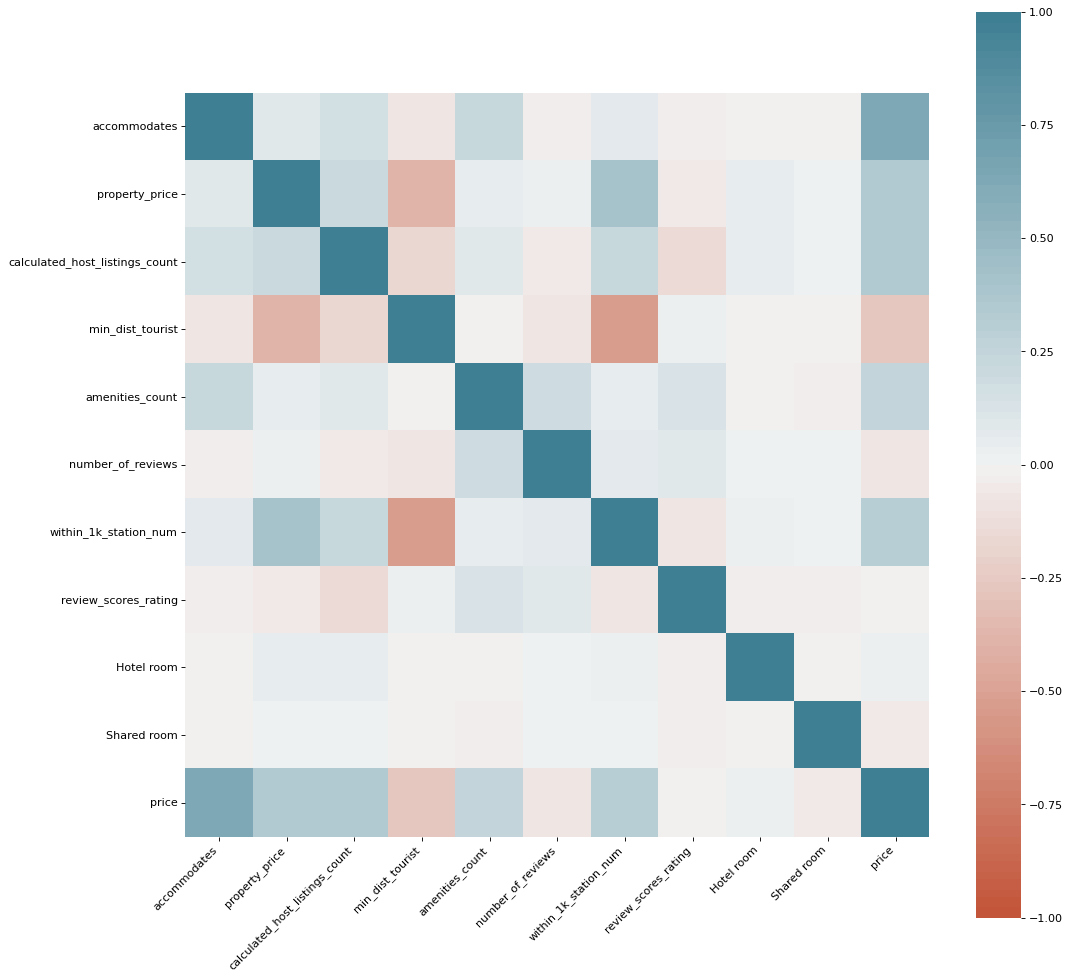

In [ ]:
figure(figsize=(15, 15), dpi=80)
corr = features_3.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=100),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

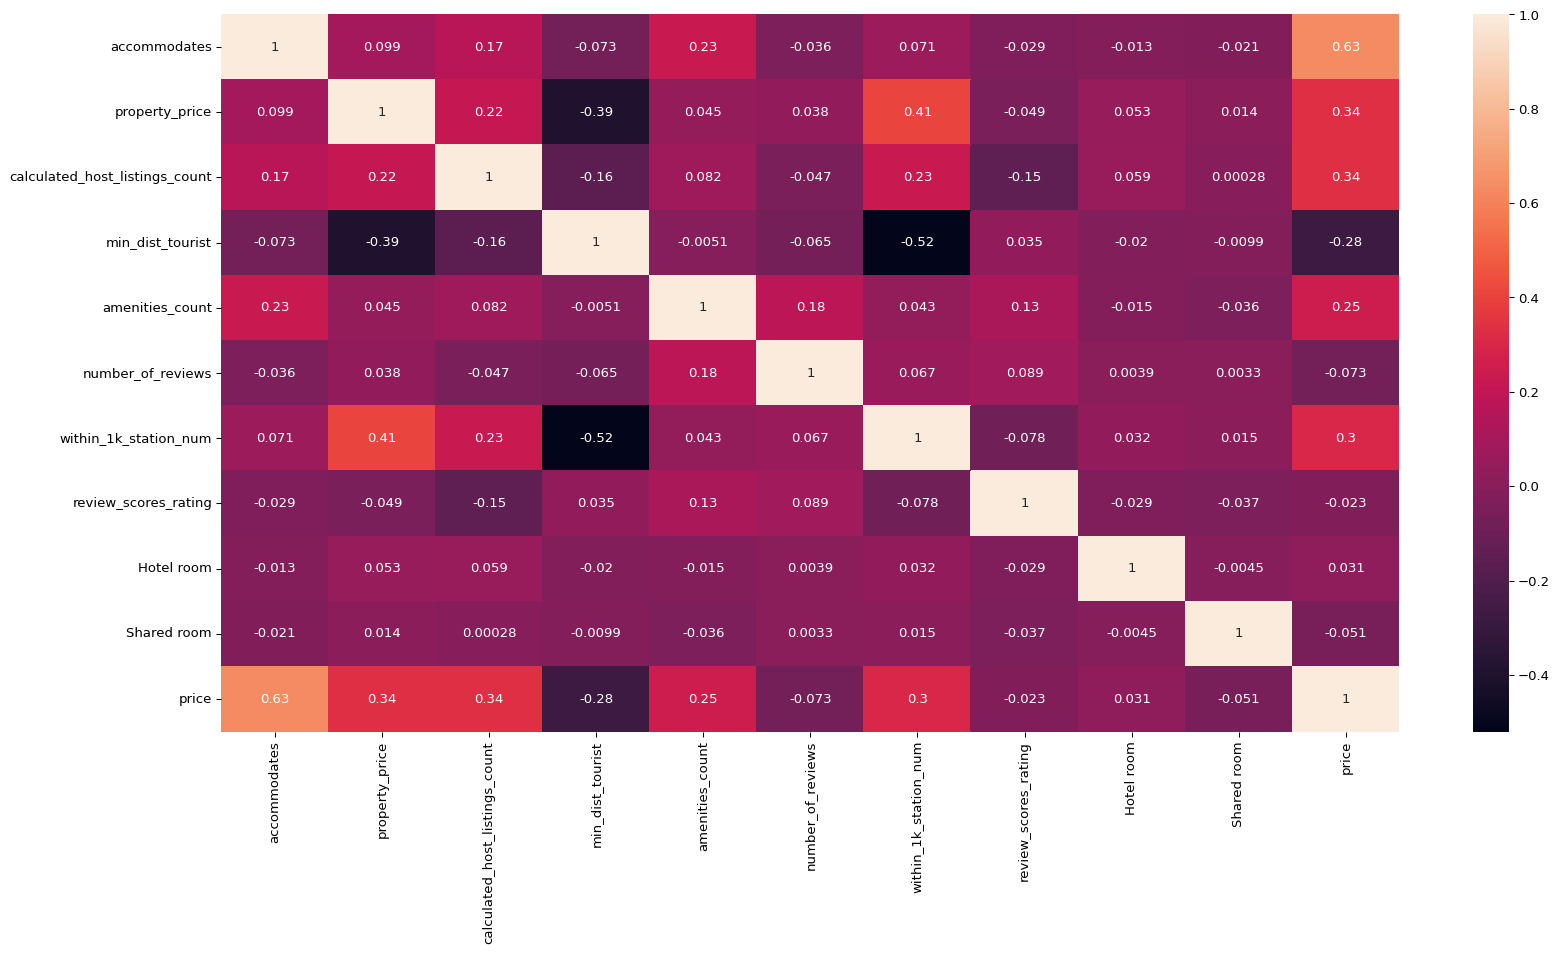

In [ ]:
import seaborn as sns
figure(figsize=(20, 10), dpi=95)
Var_Corr = features_3.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)


In [ ]:
X_variables = features_3.iloc[:,:-1]
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,accommodates,3.921781
1,property_price,8.815133
2,calculated_host_listings_count,1.443213
3,min_dist_tourist,3.571786
4,amenities_count,7.214654
5,number_of_reviews,1.655523
6,within_1k_station_num,2.836790
7,review_scores_rating,17.154886
8,Hotel room,1.010605
9,Shared room,1.006287


# Final modelling independent variables and results

In [ ]:
# removal of review score rating for high VIF

features_4 = features_3[['accommodates', 'property_price','calculated_host_listings_count','min_dist_tourist','amenities_count','number_of_reviews','within_1k_station_num','Hotel room','Shared room','price']]
X = features_4.iloc[:,:-1]
y = features_4[['price']]
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.843
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                          2.654e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                        0.00
Time:                        17:30:58   Log-Likelihood:                     -2.3805e+05
No. Observations:               44443   AIC:                                  4.761e+05
Df Residuals:                   44434   BIC:                                  4.762e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
accommodates                      21.1614      0.128    165.256      0.000      20.910      21.412
property_price                  3.976e-05   8.32e-07     47.788      0.000    3.81e-05    4.14e-05
calculated_host_listings_count     1.2887      0.028     46.322      0.000       1.234       1.343
min_dist_tourist                  -4.4311      0.109    -40.605      0.000      -4.645      -4.217
amenities_count                    0.7816      0.026     30.260      0.000       0.731       0.832
number_of_reviews                 -0.2832      0.010    -27.995      0.000      -0.303      -0.263
within_1k_station_num              3.2741      0.130     25.171      0.000       3.019       3.529
Hotel room                        19.5477      3.821      5.116      0.000      12.058      27.037
Shared room                      -44.7924      3.460    -12.945      0.000     -51.575     -38.010
==============================================================================
Omnibus:                     9578.205   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27041.213
Skew:                           1.141   Prob(JB):                         0.00
Kurtosis:                       6.065   Cond. No.                     1.13e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X_variables = features_4.iloc[:,:-1]
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,accommodates,3.775193
1,property_price,6.022764
2,calculated_host_listings_count,1.428209
3,min_dist_tourist,2.509411
4,amenities_count,6.054764
5,number_of_reviews,1.633967
6,within_1k_station_num,2.748819
7,Hotel room,1.010437
8,Shared room,1.006176


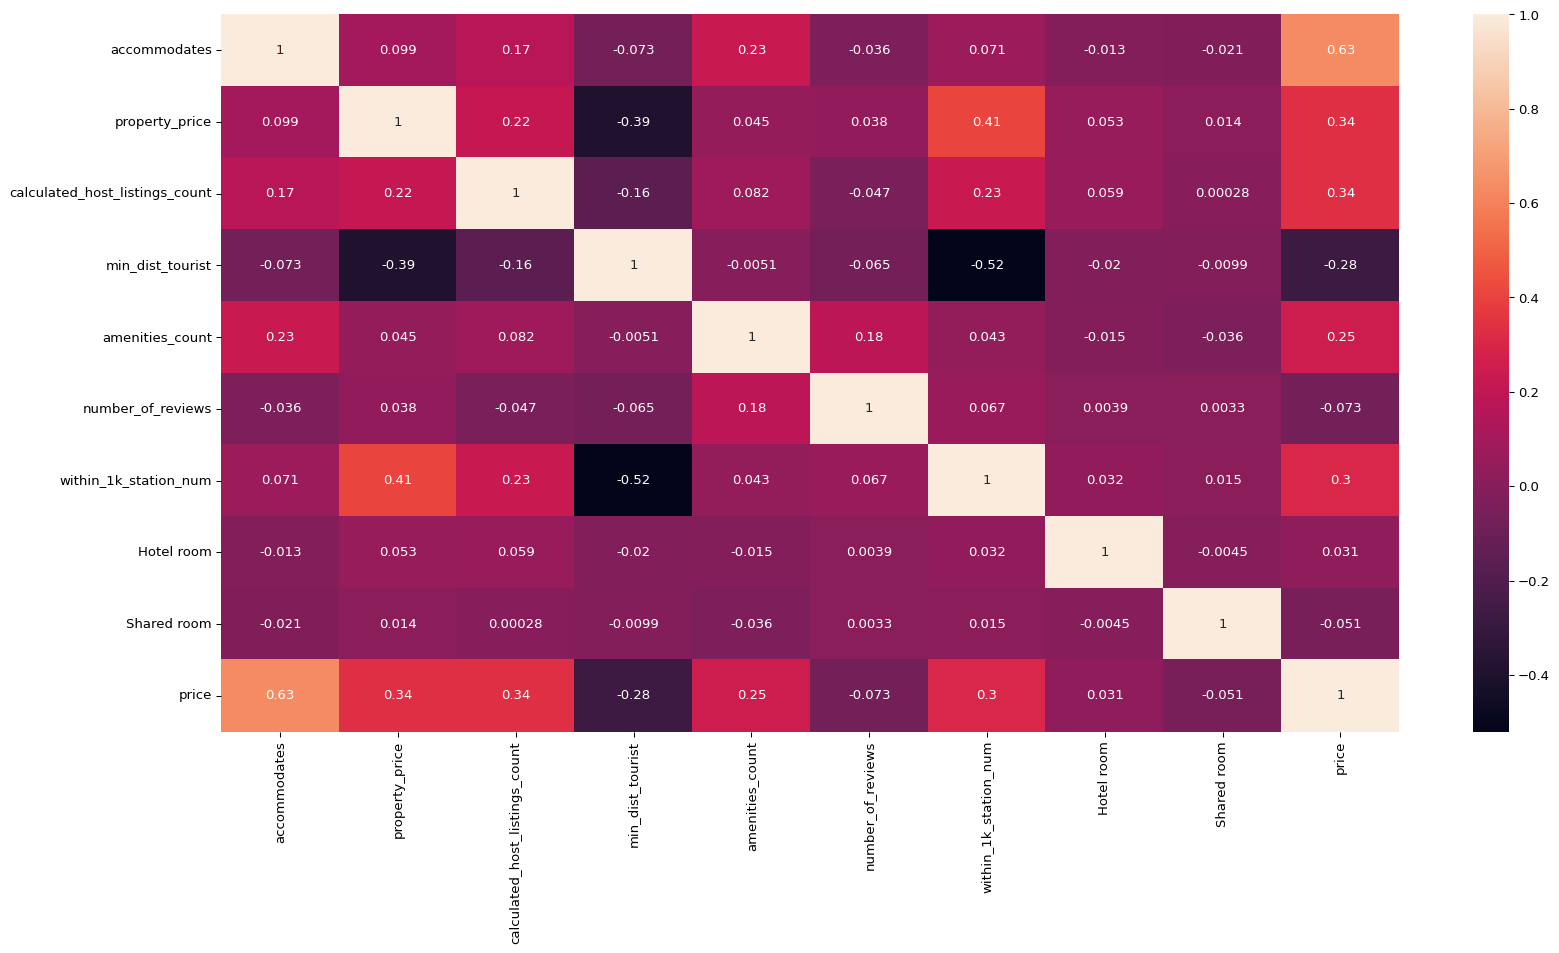

In [ ]:
import seaborn as sns
figure(figsize=(20, 10), dpi=95)
Var_Corr = features_4.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text major ticklabel objects>)

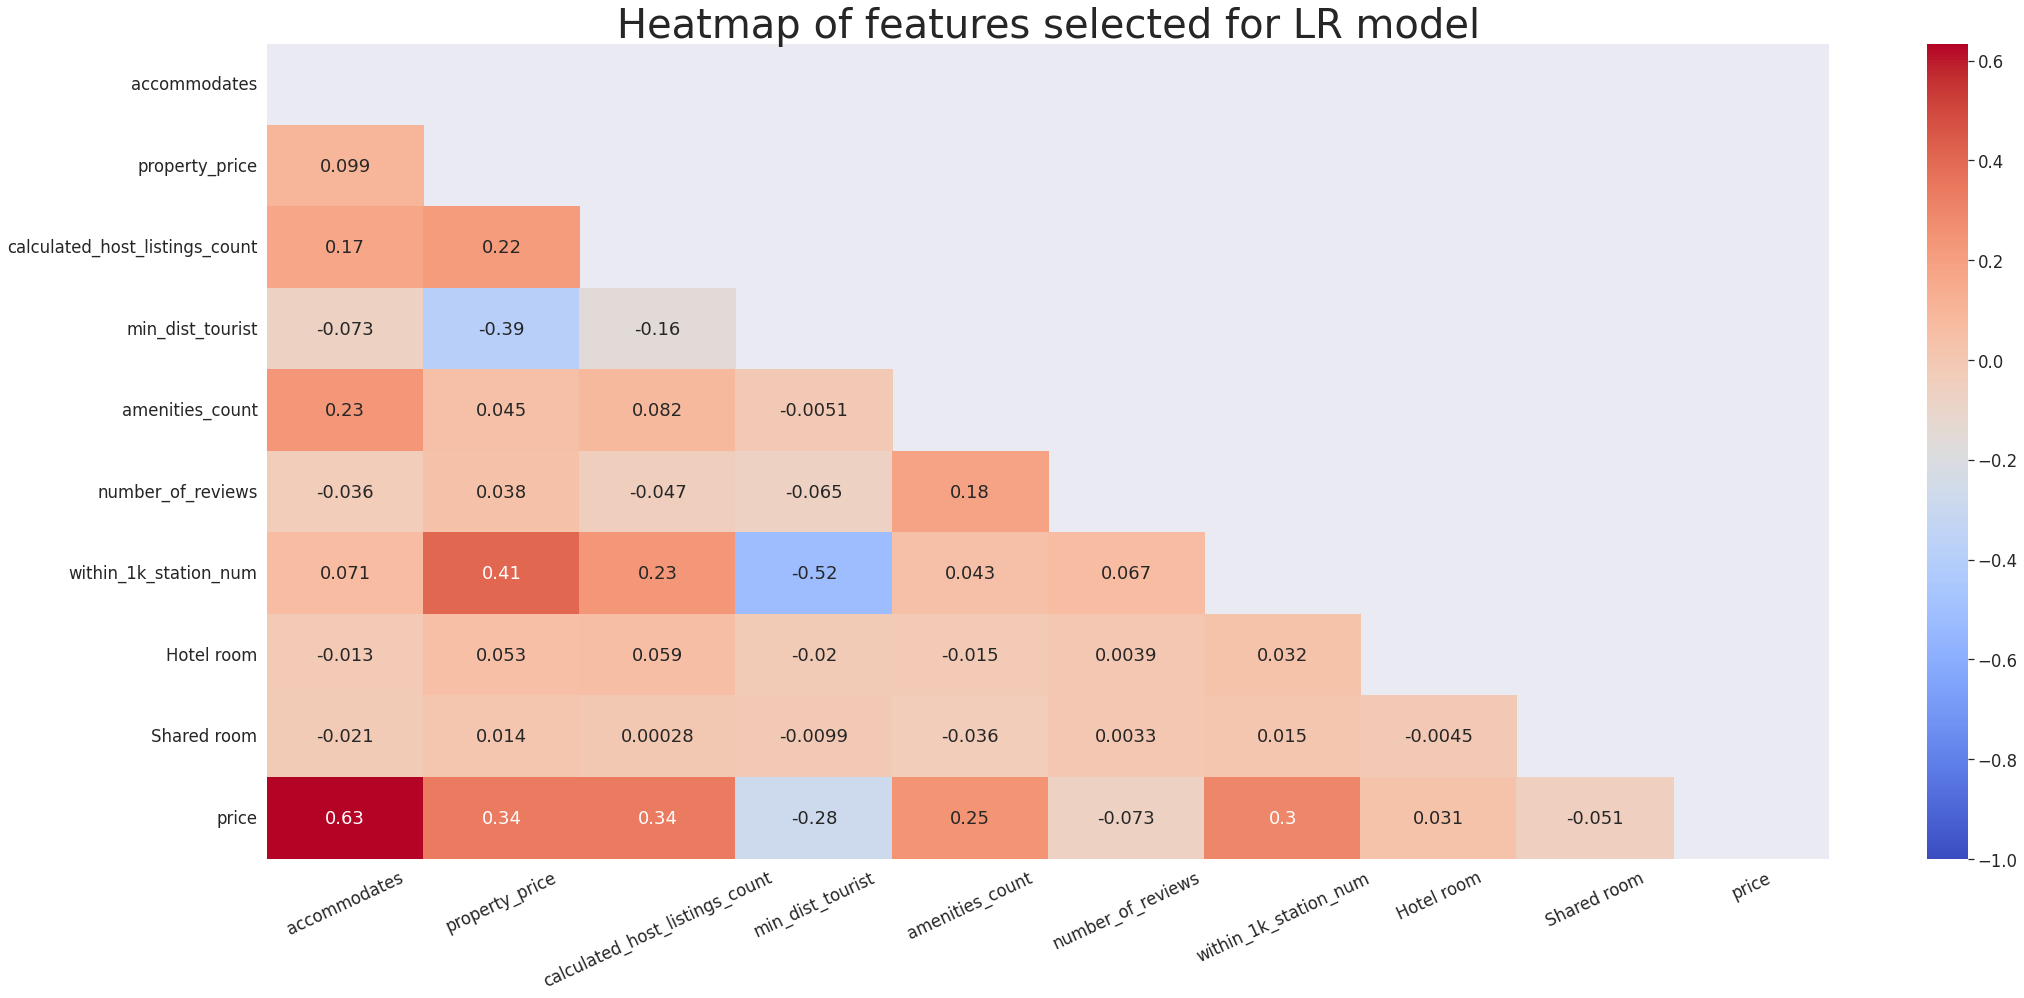

In [ ]:
mask = np.zeros_like(Var_Corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(35,15))
sns.set(font_scale=1.5)
sns.heatmap(Var_Corr,
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            mask = mask)
plt.title('Heatmap of features selected for LR model', fontsize = 40) # title with fontsize 20
plt.xticks(rotation=25)

In [ ]:
X_variables = features_3.iloc[:,:-1]
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,accommodates,3.921781
1,property_price,8.815133
2,calculated_host_listings_count,1.443213
3,min_dist_tourist,3.571786
4,amenities_count,7.214654
5,number_of_reviews,1.655523
6,within_1k_station_num,2.836790
7,review_scores_rating,17.154886
8,Hotel room,1.010605
9,Shared room,1.006287


## Perform Durbin-Watson test

H0 (null hypothesis): There is no correlation among the residuals.

HA (alternative hypothesis): The residuals are autocorrelated.

The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals. Thus, the test statistic will always be between 0 and 4 with the following interpretation:

A test statistic of 2 indicates no serial correlation.
The closer the test statistics is to 0, the more evidence of positive serial correlation.
The closer the test statistics is to 4, the more evidence of negative serial correlation.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model.resid)

## The test statistic is 1.8. Since this is within the range of 1.5 and 2.5, we would consider autocorrelation not to be problematic in this regression model.

1.7938979266745771

## Normality of the Residuals

Text(0, 0.5, 'Ordered Values')

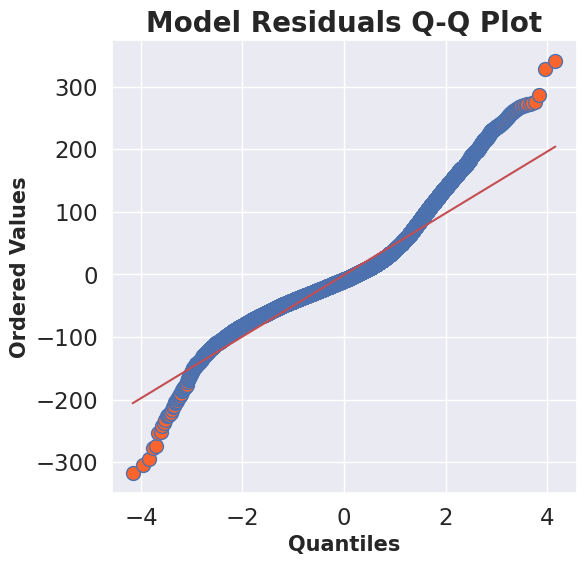

In [ ]:
from scipy import stats
#Running plot & giving it a title
fig = plt.figure(figsize=[6, 6], dpi=100)
ax = fig.add_subplot(111)
fig = stats.probplot(model.resid, dist="norm", plot= plt, fit=False)
plt.title("Model Residuals Q-Q Plot",fontsize=20, fontweight='bold')
ax.get_lines()[0].set_markerfacecolor('#FC642D')
ax.get_lines()[0].set_markersize(10.0)
ax.set_xlabel("Quantiles", fontsize=15, fontweight='bold')
ax.set_ylabel("Ordered Values", fontsize=15, fontweight='bold')